# Hyperparameter Optimization (HPO) of Machine Learning Models
L. Yang and A. Shami, “On hyperparameter optimization of machine learning algorithms: Theory and practice,” Neurocomputing, vol. 415, pp. 295–316, 2020, doi: https://doi.org/10.1016/j.neucom.2020.07.061.

### **Sample code for classification problems**  
**Dataset used:**  
&nbsp; MNIST from sklearn

**Machine learning algorithms used:**  
&nbsp; Random forest (RF), support vector machine (SVM), k-nearest neighbor (KNN), artificial neural network (ANN)

**HPO algorithms used:**  
&nbsp; Grid search, random search, hyperband, Bayesian Optimization with Gaussian Processes (BO-GP), Bayesian Optimization with Tree-structured Parzen Estimator (BO-TPE), particle swarm optimization (PSO), genetic algorithm (GA).

**Performance metric:**  
&nbsp; Classification accuracy

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.svm import SVC,SVR
from sklearn import datasets
import scipy.stats as stats

## Load MNIST dataset
The MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems. The MNIST database has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.

You can read more about the data and the variables [[1]](http://yann.lecun.com/exdb/mnist/) [[2]](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits/).

In [16]:
d = datasets.load_digits()
X = d.data
y = d.target

In [17]:
d

{'data': array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.],
        [ 0.,  0.,  0., ..., 16.,  9.,  0.],
        ...,
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  2., ..., 12.,  0.,  0.],
        [ 0.,  0., 10., ..., 12.,  1.,  0.]], shape=(1797, 64)),
 'target': array([0, 1, 2, ..., 8, 9, 8], shape=(1797,)),
 'frame': None,
 'feature_names': ['pixel_0_0',
  'pixel_0_1',
  'pixel_0_2',
  'pixel_0_3',
  'pixel_0_4',
  'pixel_0_5',
  'pixel_0_6',
  'pixel_0_7',
  'pixel_1_0',
  'pixel_1_1',
  'pixel_1_2',
  'pixel_1_3',
  'pixel_1_4',
  'pixel_1_5',
  'pixel_1_6',
  'pixel_1_7',
  'pixel_2_0',
  'pixel_2_1',
  'pixel_2_2',
  'pixel_2_3',
  'pixel_2_4',
  'pixel_2_5',
  'pixel_2_6',
  'pixel_2_7',
  'pixel_3_0',
  'pixel_3_1',
  'pixel_3_2',
  'pixel_3_3',
  'pixel_3_4',
  'pixel_3_5',
  'pixel_3_6',
  'pixel_3_7',
  'pixel_4_0',
  'pixel_4_1',
  'pixel_4_2',
  'pixel_4_3',
  'pixel_4_4',
  'pixel_4_5',
  'pixel_4_6',
  'pixel_4_7'

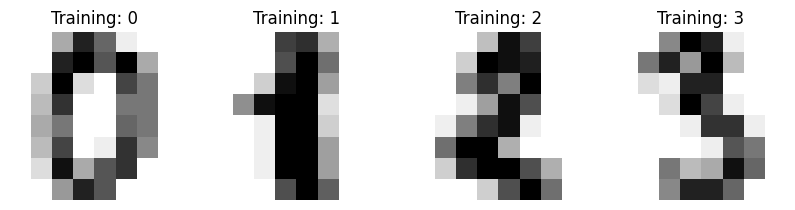

In [18]:
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, d.images, d.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Training: %i" % label)
plt.show()

## Baseline Machine Learning Models: Classifiers with Default Hyperparameters

### Using 3-Fold Cross-Validation

In [13]:
#Random Forest
clf = RandomForestClassifier()
clf.fit(X,y)
scores = cross_val_score(clf, X, y, cv=3,scoring='accuracy')
print("Accuracy:"+ str(scores.mean()))

Accuracy:0.9426822481914302


In [14]:
#SVM
clf = SVC()
clf.fit(X,y)
scores = cross_val_score(clf, X, y, cv=3,scoring='accuracy')
print("Accuracy:"+ str(scores.mean()))

Accuracy:0.9699499165275459


In [15]:
#KNN
clf = KNeighborsClassifier()
clf.fit(X,y)
scores = cross_val_score(clf, X, y, cv=3,scoring='accuracy')
print("Accuracy:"+ str(scores.mean()))

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x74d5dc3b9cf0>
Traceback (most recent call last):
  File "/home/fillip/miniconda3/envs/cpm-mor/lib/python3.10/site-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/home/fillip/miniconda3/envs/cpm-mor/lib/python3.10/site-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
  File "/home/fillip/miniconda3/envs/cpm-mor/lib/python3.10/site-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/home/fillip/miniconda3/envs/cpm-mor/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: /home/fillip/miniconda3/envs/cpm-mor/lib/python3.10/site-packages/numpy.libs/libscipy_openblas64_-6bb31eeb.so: 

Accuracy:0.9627156371730662


In [23]:
#ANN
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from sklearn.model_selection import GridSearchCV
import scikeras
from scikeras.wrappers import KerasClassifier
# from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping
def ANN(optimizer = 'sgd',neurons=32,batch_size=32,epochs=20,activation='relu',patience=3,loss='categorical_crossentropy'):
    model = Sequential()
    model.add(Dense(neurons, input_shape=(X.shape[1],), activation=activation))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(10,activation='softmax'))  # 10 is the number of classes in the dataset, you can change it based on your dataset
    model.compile(optimizer = optimizer, loss=loss)
    early_stopping = EarlyStopping(monitor="loss", patience = patience)# early stop patience
    history = model.fit(X, pd.get_dummies(y).values,
              batch_size=batch_size,
              epochs=epochs,
              callbacks = [early_stopping],
              verbose=0) #verbose set to 1 will show the training process
    return model

In [24]:
clf = KerasClassifier(build_fn=ANN, verbose=0)
scores = cross_val_score(clf, X, y, cv=3,scoring='accuracy')
print("Accuracy:"+ str(scores.mean()))

AttributeError: 'super' object has no attribute '__sklearn_tags__'

## HPO Algorithm 1: Grid Search
Search all the given hyper-parameter configurations

**Advantages:**
* Simple implementation.  

**Disadvantages:**  
* Time-consuming,
* Only efficient with categorical HPs.

In [7]:
#Random Forest
from sklearn.model_selection import GridSearchCV
# Define the hyperparameter configuration space
rf_params = {
    'n_estimators': [10, 20, 30],
    #'max_features': ['sqrt',0.5],
    'max_depth': [15,20,30,50],
    'min_samples_leaf': [1,2,4,8],
    #"bootstrap":[True,False],
    "criterion":['gini','entropy']
}
clf = RandomForestClassifier(random_state=0)
grid = GridSearchCV(clf, rf_params, cv=3, scoring='accuracy')
grid.fit(X, y)
print(grid.best_params_)
print("Accuracy:"+ str(grid.best_score_))

{'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 1, 'n_estimators': 30}
Accuracy:0.9360044518642182


In [23]:
#SVM
from sklearn.model_selection import GridSearchCV
rf_params = {
    'C': [1,10, 100],
    "kernel":['linear','poly','rbf','sigmoid']
}
clf = SVC(gamma='scale')
grid = GridSearchCV(clf, rf_params, cv=3, scoring='accuracy')
grid.fit(X, y)
print(grid.best_params_)
print("Accuracy:"+ str(grid.best_score_))

{'kernel': 'rbf', 'C': 10}
Accuracy:0.9744017807456873


In [24]:
#KNN
from sklearn.model_selection import GridSearchCV
rf_params = {
    'n_neighbors': [2, 3, 5,10,15,20],
}
clf = KNeighborsClassifier()
grid = GridSearchCV(clf, rf_params, cv=3, scoring='accuracy')
grid.fit(X, y)
print(grid.best_params_)
print("Accuracy:"+ str(grid.best_score_))

{'n_neighbors': 3}
Accuracy:0.9682804674457429


In [9]:
#ANN
from sklearn.model_selection import GridSearchCV
rf_params = {
    'optimizer': ['adam','rmsprop','sgd'],
    'activation': ['relu','tanh'],
    'batch_size': [16,32],
    'neurons':[16,32],
    'epochs':[20,50],
    'patience':[2,5]
}
clf = KerasClassifier(build_fn=ANN, verbose=0)
grid = GridSearchCV(clf, rf_params, cv=3,scoring='accuracy')
grid.fit(X, y)
print(grid.best_params_)
print("Accuracy:"+ str(grid.best_score_))

{'activation': 'relu', 'batch_size': 16, 'epochs': 50, 'neurons': 32, 'optimizer': 'adam', 'patience': 5}
Accuracy:0.9994435169727324


## HPO Algorithm 2: Random Search
Randomly search hyper-parameter combinations in the search space

**Advantages:**
* More efficient than GS.
* Enable parallelization. 

**Disadvantages:**  
* Not consider previous results.
* Not efficient with conditional HPs.

In [25]:
#Random Forest
from scipy.stats import randint as sp_randint
from random import randrange as sp_randrange
from sklearn.model_selection import RandomizedSearchCV
# Define the hyperparameter configuration space
rf_params = {
    'n_estimators': sp_randint(10,100),
    "max_features":sp_randint(1,64),
    'max_depth': sp_randint(5,50),
    "min_samples_split":sp_randint(2,11),
    "min_samples_leaf":sp_randint(1,11),
    "criterion":['gini','entropy']
}
n_iter_search=20 #number of iterations is set to 20, you can increase this number if time permits
clf = RandomForestClassifier(random_state=0)
Random = RandomizedSearchCV(clf, param_distributions=rf_params,n_iter=n_iter_search,cv=3,scoring='accuracy')
Random.fit(X, y)
print(Random.best_params_)
print("Accuracy:"+ str(Random.best_score_))

{'n_estimators': 36, 'max_features': 6, 'max_depth': 42, 'min_samples_split': 6, 'min_samples_leaf': 2, 'criterion': 'gini'}
Accuracy:0.9309961046188091


In [26]:
#SVM
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
rf_params = {
    'C': stats.uniform(0,50),
    "kernel":['linear','poly','rbf','sigmoid']
}
n_iter_search=20
clf = SVC(gamma='scale')
Random = RandomizedSearchCV(clf, param_distributions=rf_params,n_iter=n_iter_search,cv=3,scoring='accuracy')
Random.fit(X, y)
print(Random.best_params_)
print("Accuracy:"+ str(Random.best_score_))

{'kernel': 'rbf', 'C': 17.026713515892954}
Accuracy:0.9744017807456873


In [27]:
#KNN
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
rf_params = {
    'n_neighbors': range(1,20),
}
n_iter_search=10
clf = KNeighborsClassifier()
Random = RandomizedSearchCV(clf, param_distributions=rf_params,n_iter=n_iter_search,cv=3,scoring='accuracy')
Random.fit(X, y)
print(Random.best_params_)
print("Accuracy:"+ str(Random.best_score_))

{'n_neighbors': 4}
Accuracy:0.9643850862548692


In [29]:
#ANN
from scipy.stats import randint as sp_randint
from random import randrange as sp_randrange
from sklearn.model_selection import RandomizedSearchCV
rf_params = {
    'optimizer': ['adam','rmsprop','sgd'],
    'activation': ['relu','tanh'],
    'batch_size': [16,32,64],
    'neurons':sp_randint(10,100),
    'epochs':[20,50],
    #'epochs':[20,50,100,200],
    'patience':sp_randint(3,20)
}
n_iter_search=10
clf = KerasClassifier(build_fn=ANN, verbose=0)
Random = RandomizedSearchCV(clf, param_distributions=rf_params,n_iter=n_iter_search,cv=3,scoring='accuracy')
Random.fit(X, y)
print(Random.best_params_)
print("Accuracy:"+ str(Random.best_score_))

{'activation': 'relu', 'epochs': 20, 'optimizer': 'adam', 'patience': 8, 'batch_size': 16, 'neurons': 89}
Accuracy:1.0


## HPO Algorithm 3: Hyperband
Generate small-sized subsets and allocate budgets to each hyper-parameter combination based on its performance

**Advantages:**
* Enable parallelization.  

**Disadvantages:**  
* Not efficient with conditional HPs.
* Require subsets with small budgets to be representative.

In [8]:
#Random Forest
from hyperband import HyperbandSearchCV
from scipy.stats import randint as sp_randint
from random import randrange as sp_randrange
# Define the hyperparameter configuration space
rf_params = {
    'n_estimators': sp_randint(10,100),
    "max_features":sp_randint(1,64),
    'max_depth': sp_randint(5,50),
    "min_samples_split":sp_randint(2,11),
    "min_samples_leaf":sp_randint(1,11),
    "criterion":['gini','entropy']
}
clf = RandomForestClassifier(random_state=0)
hyper = HyperbandSearchCV(clf, param_distributions =rf_params,cv=3,min_iter=10,max_iter=100,scoring='accuracy')
hyper.fit(X, y)
print(hyper.best_params_)
print("Accuracy:"+ str(hyper.best_score_))

ModuleNotFoundError: No module named 'hyperband'

In [29]:
#SVM
from hyperband import HyperbandSearchCV
from scipy.stats import randint as sp_randint
from random import randrange as sp_randrange
rf_params = {
    'C': stats.uniform(0,50),
    "kernel":['linear','poly','rbf','sigmoid']
}
clf = SVC(gamma='scale')
hyper = HyperbandSearchCV(clf, param_distributions =rf_params,cv=3,min_iter=1,max_iter=50,scoring='accuracy',resource_param='C')
hyper.fit(X, y)
print(hyper.best_params_)
print("Accuracy:"+ str(hyper.best_score_))

{'kernel': 'rbf', 'C': 16}
Accuracy:0.9744017807456873


In [30]:
#KNN
from hyperband import HyperbandSearchCV
from scipy.stats import randint as sp_randint
from random import randrange as sp_randrange
rf_params = {
    'n_neighbors': range(1,20),
}
clf = KNeighborsClassifier()
hyper = HyperbandSearchCV(clf, param_distributions =rf_params,cv=3,min_iter=1,max_iter=20,scoring='accuracy',resource_param='n_neighbors')
hyper.fit(X, y)
print(hyper.best_params_)
print("Accuracy:"+ str(hyper.best_score_))

{'n_neighbors': 2}
Accuracy:0.9621591541457986


In [30]:
#ANN
from hyperband import HyperbandSearchCV
from scipy.stats import randint as sp_randint
rf_params = {
    'optimizer': ['adam','rmsprop','sgd'],
    'activation': ['relu','tanh'],
    'batch_size': [16,32,64],
    'neurons':sp_randint(10,100),
    'epochs':[20,50],
    #'epochs':[20,50,100,200],
    'patience':sp_randint(3,20)
}
clf = KerasClassifier(build_fn=ANN, epochs=20, verbose=0)
hyper = HyperbandSearchCV(clf, param_distributions =rf_params,cv=3,min_iter=1,max_iter=10,scoring='accuracy',resource_param='epochs')
hyper.fit(X, y)
print(hyper.best_params_)
print("Accuracy:"+ str(hyper.best_score_))

{'activation': 'tanh', 'epochs': 10, 'batch_size': 16, 'patience': 7, 'optimizer': 'adam', 'neurons': 76}
Accuracy:0.9994435169727324


## HPO Algorithm 4: BO-GP
Bayesian Optimization with Gaussian Process (BO-GP)

**Advantages:**
* Fast convergence speed for continuous HPs.  

**Disadvantages:**  
* Poor capacity for parallelization.
* Not efficient with conditional HPs.

### Using skopt.BayesSearchCV

In [9]:
#Random Forest
from skopt import Optimizer
from skopt import BayesSearchCV 
from skopt.space import Real, Categorical, Integer
# Define the hyperparameter configuration space
rf_params = {
    'n_estimators': Integer(10,100),
    "max_features":Integer(1,64),
    'max_depth': Integer(5,50),
    "min_samples_split":Integer(2,11),
    "min_samples_leaf":Integer(1,11),
    "criterion":['gini','entropy']
}
clf = RandomForestClassifier(random_state=0)
Bayes = BayesSearchCV(clf, rf_params,cv=3,n_iter=20, n_jobs=-1,scoring='accuracy')
#number of iterations is set to 20, you can increase this number if time permits
Bayes.fit(X, y)
print(Bayes.best_params_)
bclf = Bayes.best_estimator_
print("Accuracy:"+ str(Bayes.best_score_))

OrderedDict([('criterion', 'gini'), ('max_depth', 16), ('max_features', 4), ('min_samples_leaf', 2), ('min_samples_split', 4), ('n_estimators', 96)])
Accuracy:0.9382303839732887


In [32]:
#SVM
from skopt import Optimizer
from skopt import BayesSearchCV 
from skopt.space import Real, Categorical, Integer
rf_params = {
    'C': Real(0.01,50),
    "kernel":['linear','poly','rbf','sigmoid']
}
clf = SVC(gamma='scale')
Bayes = BayesSearchCV(clf, rf_params,cv=3,n_iter=20, n_jobs=-1,scoring='accuracy')
Bayes.fit(X, y)
print(Bayes.best_params_)
bclf = Bayes.best_estimator_
print("Accuracy:"+ str(Bayes.best_score_))

{'kernel': 'rbf', 'C': 26.52140440440126}
Accuracy:0.9744017807456873


In [33]:
#KNN
from skopt import Optimizer
from skopt import BayesSearchCV 
from skopt.space import Real, Categorical, Integer
rf_params = {
    'n_neighbors': Integer(1,20),
}
clf = KNeighborsClassifier()
Bayes = BayesSearchCV(clf, rf_params,cv=3,n_iter=10, n_jobs=-1,scoring='accuracy')
Bayes.fit(X, y)
print(Bayes.best_params_)
bclf = Bayes.best_estimator_
print("Accuracy:"+ str(Bayes.best_score_))

{'n_neighbors': 3}
Accuracy:0.9682804674457429


In [31]:
#ANN
from skopt import Optimizer
from skopt import BayesSearchCV 
from skopt.space import Real, Categorical, Integer
rf_params = {
    'optimizer': ['adam','rmsprop','sgd'],
    'activation': ['relu','tanh'],
    'batch_size': [16,32,64],
    'neurons':Integer(10,100),
    'epochs':[20,50],
    #'epochs':[20,50,100,200],
    'patience':Integer(3,20)
}
clf = KerasClassifier(build_fn=ANN, verbose=0)
Bayes = BayesSearchCV(clf, rf_params,cv=3,n_iter=10, scoring='accuracy')
Bayes.fit(X, y)
print(Bayes.best_params_)
print("Accuracy:"+ str(Bayes.best_score_))

{'activation': 'tanh', 'epochs': 47, 'optimizer': 'adam', 'patience': 10, 'batch_size': 16, 'neurons': 54}
Accuracy:1.0


### Using skopt.gp_minimize

In [34]:
#Random Forest
from skopt.space import Real, Integer
from skopt.utils import use_named_args

reg = RandomForestClassifier()
# Define the hyperparameter configuration space
space  = [Integer(10, 100, name='n_estimators'),
            Integer(5, 50, name='max_depth'),
          Integer(1, 64, name='max_features'),
          Integer(2, 11, name='min_samples_split'),
          Integer(1, 11, name='min_samples_leaf'),
         Categorical(['gini', 'entropy'], name='criterion'),]
# Define the objective function
@use_named_args(space)
def objective(**params):
    reg.set_params(**params)

    return -np.mean(cross_val_score(reg, X, y, cv=3, n_jobs=-1,
                                    scoring="accuracy"))
from skopt import gp_minimize
res_gp = gp_minimize(objective, space, n_calls=20, random_state=0)
print("Accuracy:%.4f" % -res_gp.fun)
print(res_gp.x)

Accuracy:0.9293
[100, 50, 1, 11, 1, 'entropy']


In [35]:
#SVM
from skopt.space import Real, Integer
from skopt.utils import use_named_args

reg = SVC(gamma='scale')
space  = [Real(0.01, 50, name='C'),
          Categorical(['linear','poly','rbf','sigmoid'], name='kernel'),
         ]

@use_named_args(space)
def objective(**params):
    reg.set_params(**params)

    return -np.mean(cross_val_score(reg, X, y, cv=3, n_jobs=-1,
                                    scoring="accuracy"))
from skopt import gp_minimize
res_gp = gp_minimize(objective, space, n_calls=20, random_state=0)
print("Accuracy:%.4f" % -res_gp.fun)
print(res_gp.x)

Accuracy:0.9744
[16.876434059259253, 'rbf']


In [36]:
#KNN
from skopt.space import Real, Integer
from skopt.utils import use_named_args

reg = KNeighborsClassifier()
space  = [Integer(1, 20, name='n_neighbors')]

@use_named_args(space)
def objective(**params):
    reg.set_params(**params)

    return -np.mean(cross_val_score(reg, X, y, cv=3, n_jobs=-1,
                                    scoring="accuracy"))
from skopt import gp_minimize
res_gp = gp_minimize(objective, space, n_calls=10, random_state=0)
print("Accuracy:%.4f" % -res_gp.fun)
print(res_gp.x)

Accuracy:0.9622
[2]


## HPO Algorithm 5: BO-TPE
Bayesian Optimization with Tree-structured Parzen Estimator (TPE)

**Advantages:**
* Efficient with all types of HPs.
* Keep conditional dependencies.

**Disadvantages:**  
* Poor capacity for parallelization.

In [37]:
#Random Forest
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = RandomForestClassifier( **params)
    score = cross_val_score(clf, X, y, scoring='accuracy', cv=StratifiedKFold(n_splits=3)).mean()
    #print("ROC-AUC {:.3f} params {}".format(score, params))

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 64, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

100%|██████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.76it/s, best loss: -0.9348679045482652]
Random Forest: Hyperopt estimated optimum {'n_estimators': 95.0, 'max_features': 13.0, 'max_depth': 39.0, 'min_samples_split': 3.0, 'min_samples_leaf': 2.0, 'criterion': 0}


In [32]:
#SVM
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
def objective(params):
    params = {
        'C': abs(float(params['C'])), 
        "kernel":str(params['kernel'])
    }
    clf = SVC(gamma='scale', **params)
    score = cross_val_score(clf, X, y, scoring='accuracy', cv=StratifiedKFold(n_splits=3)).mean()

    return {'loss':-score, 'status': STATUS_OK }

space = {
    'C': hp.normal('C', 0, 50),
    "kernel":hp.choice('kernel',['linear','poly','rbf','sigmoid'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("SVM: Hyperopt estimated optimum {}".format(best))

100%|██████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.18it/s, best loss: -0.9749661645191837]
SVM: Hyperopt estimated optimum {'kernel': 2, 'C': 5.89740125613865}


In [33]:
#KNN
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
def objective(params):
    params = {
        'n_neighbors': abs(int(params['n_neighbors']))
    }
    clf = KNeighborsClassifier( **params)
    score = cross_val_score(clf, X, y, scoring='accuracy', cv=StratifiedKFold(n_splits=3)).mean()

    return {'loss':-score, 'status': STATUS_OK }

space = {
    'n_neighbors': hp.quniform('n_neighbors', 1, 20, 1),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)
print("KNN: Hyperopt estimated optimum {}".format(best))

100%|███████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.34it/s, best loss: -0.968293886616605]
KNN: Hyperopt estimated optimum {'n_neighbors': 3.0}


In [34]:
#ANN
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
def objective(params):
    params = {
        "optimizer":str(params['optimizer']),
        "activation":str(params['activation']),
        'batch_size': abs(int(params['batch_size'])),
        'neurons': abs(int(params['neurons'])),
        'epochs': abs(int(params['epochs'])),
        'patience': abs(int(params['patience']))
    }
    clf = KerasClassifier(build_fn=ANN,**params, verbose=0)
    score = -np.mean(cross_val_score(clf, X, y, cv=3, 
                                    scoring="accuracy"))

    return {'loss':score, 'status': STATUS_OK }

space = {
    "optimizer":hp.choice('optimizer',['adam','rmsprop','sgd']),
    "activation":hp.choice('activation',['relu','tanh']),
    'batch_size': hp.quniform('batch_size', 16, 64, 16),
    'neurons': hp.quniform('neurons', 10, 100, 10),
    'epochs': hp.quniform('epochs', 20, 50, 10),
    'patience': hp.quniform('patience', 3, 20, 3),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)
print("ANN: Hyperopt estimated optimum {}".format(best))

100%|█████████████████████████████████████████████████████████████████| 10/10 [06:29<00:00, 38.92s/it, best loss: -1.0]
ANN: Hyperopt estimated optimum {'activation': 1, 'epochs': 30.0, 'optimizer': 0, 'patience': 9.0, 'batch_size': 48.0, 'neurons': 60.0}


## HPO Algorithm 6: PSO
Partical swarm optimization (PSO): Each particle in a swarm communicates with other particles to detect and update the current global optimum in each iteration until the final optimum is detected.

**Advantages:**
* Efficient with all types of HPs.
* Enable parallelization. 

**Disadvantages:**  
* Require proper initialization.

In [40]:
#Random Forest
import optunity
import optunity.metrics

data=X
labels=y.tolist()
# Define the hyperparameter configuration space
search = {
    'n_estimators': [10, 100],
    'max_features': [1, 64],
    'max_depth': [5,50],
    "min_samples_split":[2,11],
    "min_samples_leaf":[1,11],
    "criterion":[0,1]
         }
# Define the objective function
@optunity.cross_validated(x=data, y=labels, num_folds=3)
def performance(x_train, y_train, x_test, y_test,n_estimators=None, max_features=None,max_depth=None,min_samples_split=None,min_samples_leaf=None,criterion=None):
    # fit the model
    if criterion<0.5:
        cri='gini'
    else:
        cri='entropy'
    model = RandomForestClassifier(n_estimators=int(n_estimators),
                                   max_features=int(max_features),
                                   max_depth=int(max_depth),
                                   min_samples_split=int(min_samples_split),
                                   min_samples_leaf=int(min_samples_leaf),
                                   criterion=cri,
                                  )
    #predictions = model.predict(x_test)
    scores=np.mean(cross_val_score(model, X, y, cv=3, n_jobs=-1,
                                    scoring="accuracy"))
    #return optunity.metrics.roc_auc(y_test, predictions, positive=True)
    return scores#optunity.metrics.accuracy(y_test, predictions)

optimal_configuration, info, _ = optunity.maximize(performance,
                                                  solver_name='particle swarm',
                                                  num_evals=20,
                                                   **search
                                                  )
print(optimal_configuration)
print("Accuracy:"+ str(info.optimum))

{'n_estimators': 72.7099609375, 'max_features': 7.49072265625, 'max_depth': 28.31298828125, 'min_samples_split': 10.63525390625, 'min_samples_leaf': 5.6337890625, 'criterion': 0.22998046875}
Accuracy:0.9255791726758763


In [43]:
#SVM
import optunity
import optunity.metrics

data=X
labels=y.tolist()

search = {
    'C': (0,50),
    'kernel':[0,4]
         }
@optunity.cross_validated(x=data, y=labels, num_folds=3)
def performance(x_train, y_train, x_test, y_test,C=None,kernel=None):
    # fit the model
    if kernel<1:
        ke='linear'
    elif kernel<2:
        ke='poly'
    elif kernel<3:
        ke='rbf'
    else:
        ke='sigmoid'
    model = SVC(C=float(C),
                kernel=ke
                                  )
    #predictions = model.predict(x_test)
    scores=np.mean(cross_val_score(model, X, y, cv=3, n_jobs=-1,
                                    scoring="accuracy"))
    #return optunity.metrics.roc_auc(y_test, predictions, positive=True)
    return scores#optunity.metrics.accuracy(y_test, predictions)

optimal_configuration, info, _ = optunity.maximize(performance,
                                                  solver_name='particle swarm',
                                                  num_evals=20,
                                                   **search
                                                  )
print(optimal_configuration)
print("Accuracy:"+ str(info.optimum))

{'kernel': 1.55078125, 'C': 47.998046875}
Accuracy:0.9604833211865952


In [42]:
#KNN
import optunity
import optunity.metrics

data=X
labels=y.tolist()

search = {
    'n_neighbors': [1, 20],
         }
@optunity.cross_validated(x=data, y=labels, num_folds=3)
def performance(x_train, y_train, x_test, y_test,n_neighbors=None):
    # fit the model
    model = KNeighborsClassifier(n_neighbors=int(n_neighbors),
                                  )
    scores=np.mean(cross_val_score(model, X, y, cv=3, n_jobs=-1,
                                    scoring="accuracy"))
    return scores

optimal_configuration, info, _ = optunity.maximize(performance,
                                                  solver_name='particle swarm',
                                                  num_evals=10,
                                                   **search
                                                  )
print(optimal_configuration)
print("Accuracy:"+ str(info.optimum))

{'n_neighbors': 3.12451171875}
Accuracy:0.968293886616605


In [10]:
#ANN
import optunity
import optunity.metrics

data=X
labels=y.tolist()

search = {
    'optimizer':[0,3],
    'activation':[0,2],
    'batch_size': [0, 2],
    'neurons': [10, 100],
    'epochs': [20, 50],
    'patience': [3, 20],
         }
@optunity.cross_validated(x=data, y=labels, num_folds=3)
def performance(x_train, y_train, x_test, y_test,optimizer=None,activation=None,batch_size=None,neurons=None,epochs=None,patience=None):
    # fit the model
    if optimizer<1:
        op='adam'
    elif optimizer<2:
        op='sgd'
    else:
        op='rmsprop'
    if activation<1:
        ac='relu'
    else:
        ac='tanh'
    if batch_size<1:
        ba=16
    else:
        ba=32
    model = ANN(optimizer=op,
                activation=ac,
                batch_size=ba,
                neurons=int(neurons),
                epochs=int(epochs),
                patience=int(patience)
                                  )
    clf = KerasClassifier(build_fn=ANN, verbose=0)
    scores=np.mean(cross_val_score(clf, X, y, cv=3, 
                                    scoring="accuracy"))

    return scores

optimal_configuration, info, _ = optunity.maximize(performance,
                                                  solver_name='particle swarm',
                                                  num_evals=20,
                                                   **search
                                                  )
print(optimal_configuration)
print("Accuracy:"+ str(info.optimum))

{'optimizer': 1.614455714955763, 'activation': 0.41885608906506233, 'batch_size': 1.1755859375, 'neurons': 79.7763671875, 'epochs': 21.244529758913554, 'patience': 3.140998456489326}
Accuracy:0.9907252828788723


## HPO Algorithm 7: Genetic Algorithm
Genetic algorithms detect well-performing hyper-parameter combinations in each generation, and pass them to the next generation until the best-performing combination is identified.

**Advantages:**
* Efficient with all types of HPs.
* Not require good initialization.
 

**Disadvantages:**  
* Poor capacity for parallelization.

### Using DEAP

In [44]:
#Random Forest
from evolutionary_search import EvolutionaryAlgorithmSearchCV
# Define the hyperparameter configuration space
rf_params = {
    'n_estimators': np.logspace(1,1.8,num = 10 ,base=20,dtype='int'),
    'max_depth': np.logspace(1,2,num = 10 ,base=10,dtype='int'),
    "max_features":np.logspace(0.2,1,num = 5 ,base=8,dtype='int'),
    "min_samples_split":np.logspace(0.4, 1, num=5, base=10, dtype='int'), #[2, 3, 5, 7, 10],
    "min_samples_leaf":np.logspace(0.1,1,num = 5 ,base=11,dtype='int'),
    "criterion":['gini','entropy']
}
rf_params = {
    'n_estimators': range(10,100),
    "max_features":range(1,64),
    'max_depth': range(5,50),
    "min_samples_split":range(2,11),
    "min_samples_leaf":range(1,11),
    #Categorical(name='criterion', categories=['gini','entropy'])#
    "criterion":['gini','entropy']
}
clf = RandomForestClassifier(random_state=0)
# Set the hyperparameters of GA 
ga1 = EvolutionaryAlgorithmSearchCV(estimator=clf,
                                   params=rf_params,
                                   scoring="accuracy",
                                   cv=3,
                                   verbose=1,
                                   population_size=10,
                                   gene_mutation_prob=0.10,
                                   gene_crossover_prob=0.5,
                                   tournament_size=3,
                                   generations_number=5,
                                   n_jobs=1)
ga1.fit(X, y)
print(ga1.best_params_)
print("Accuracy:"+ str(ga1.best_score_))

Types [1, 1, 1, 1, 1, 1] and maxint [89, 62, 44, 8, 9, 1] detected
--- Evolve in 45927000 possible combinations ---
gen	nevals	avg     	min     	max     	std      
0  	10    	0.898664	0.871452	0.920423	0.0133659
1  	8     	0.90345 	0.883139	0.919866	0.00932254
2  	6     	0.911408	0.902059	0.919866	0.00498231
3  	6     	0.914969	0.904285	0.919866	0.00508078
4  	6     	0.918976	0.913189	0.919866	0.0020401 
5  	6     	0.919588	0.917084	0.919866	0.000834725
Best individual is: {'n_estimators': 38, 'max_features': 3, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini'}
with fitness: 0.9204229271007234
{'n_estimators': 38, 'max_features': 3, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini'}
Accuracy:0.9204229271007234


In [45]:
#SVM
from evolutionary_search import EvolutionaryAlgorithmSearchCV
rf_params = {
    'C': np.random.uniform(0,50,1000),
    "kernel":['linear','poly','rbf','sigmoid']
}
clf = SVC(gamma='scale')
ga1 = EvolutionaryAlgorithmSearchCV(estimator=clf,
                                   params=rf_params,
                                   scoring="accuracy",
                                   cv=3,
                                   verbose=1,
                                   population_size=10,
                                   gene_mutation_prob=0.10,
                                   gene_crossover_prob=0.5,
                                   tournament_size=3,
                                   generations_number=5,
                                   n_jobs=1)
ga1.fit(X, y)
print(ga1.best_params_)
print("Accuracy:"+ str(ga1.best_score_))

Types [1, 2] and maxint [3, 999] detected
--- Evolve in 4000 possible combinations ---
gen	nevals	avg     	min     	max     	std     
0  	10    	0.906177	0.760156	0.974402	0.089037
1  	7     	0.949527	0.753478	0.974402	0.0655796
2  	7     	0.974402	0.974402	0.974402	0        
3  	6     	0.952977	0.760156	0.974402	0.0642738
4  	4     	0.974402	0.974402	0.974402	0        
5  	3     	0.971341	0.943795	0.974402	0.00918197
Best individual is: {'kernel': 'rbf', 'C': 26.705081969400556}
with fitness: 0.9744017807456873
{'kernel': 'rbf', 'C': 26.705081969400556}
Accuracy:0.9744017807456873


In [46]:
#KNN
from evolutionary_search import EvolutionaryAlgorithmSearchCV
rf_params = {
    'n_neighbors': range(1,20),
}
clf = KNeighborsClassifier()
ga1 = EvolutionaryAlgorithmSearchCV(estimator=clf,
                                   params=rf_params,
                                   scoring="accuracy",
                                   cv=3,
                                   verbose=1,
                                   population_size=10,
                                   gene_mutation_prob=0.10,
                                   gene_crossover_prob=0.5,
                                   tournament_size=3,
                                   generations_number=5,
                                   n_jobs=1)
ga1.fit(X, y)
print(ga1.best_params_)
print("Accuracy:"+ str(ga1.best_score_))

Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---
gen	nevals	avg     	min     	max    	std       
0  	10    	0.955092	0.946578	0.96828	0.00705242
1  	7     	0.962994	0.951029	0.96828	0.00558289
2  	5     	0.967501	0.964385	0.96828	0.00155815
3  	8     	0.967891	0.964385	0.96828	0.00116861
4  	8     	0.966221	0.947691	0.96828	0.00617696
5  	6     	0.96828 	0.96828 	0.96828	0         
Best individual is: {'n_neighbors': 3}
with fitness: 0.9682804674457429
{'n_neighbors': 3}
Accuracy:0.9682804674457429


In [36]:
#ANN
from evolutionary_search import EvolutionaryAlgorithmSearchCV
# Define the hyperparameter configuration space
rf_params = {
    'optimizer': ['adam','rmsprop','sgd'],
    'activation': ['relu','tanh'],
    'batch_size': [16,32,64],
    'neurons':range(10,100),
    'epochs':[20,50],
    #'epochs':[20,50,100,200],
    'patience':range(3,20)
}
clf = KerasClassifier(build_fn=ANN, verbose=0)
# Set the hyperparameters of GA    
ga1 = EvolutionaryAlgorithmSearchCV(estimator=clf,
                                   params=rf_params,
                                   scoring="accuracy",
                                   cv=3,
                                   verbose=1,
                                   population_size=10,
                                   gene_mutation_prob=0.10,
                                   gene_crossover_prob=0.5,
                                   tournament_size=3,
                                   generations_number=5,
                                   n_jobs=1)
ga1.fit(X, y)
print(ga1.best_params_)
print("Accuracy:"+ str(ga1.best_score_))

Types [1, 1, 1, 1, 1, 1] and maxint [1, 1, 2, 16, 2, 89] detected
--- Evolve in 55080 possible combinations ---
gen	nevals	avg     	min    	max     	std      
0  	10    	0.985031	0.93044	0.999444	0.0217448
1  	6     	0.998164	0.995548	0.999444	0.00174296
2  	4     	0.999444	0.999444	0.999444	1.11022e-16
3  	3     	0.999444	0.999444	0.999444	1.11022e-16
4  	6     	0.999444	0.999444	0.999444	1.11022e-16
5  	8     	0.999444	0.999444	0.999444	1.11022e-16
Best individual is: {'activation': 'relu', 'epochs': 50, 'optimizer': 'sgd', 'patience': 14, 'batch_size': 16, 'neurons': 64}
with fitness: 0.9994435169727324
{'activation': 'relu', 'epochs': 50, 'optimizer': 'sgd', 'patience': 14, 'batch_size': 16, 'neurons': 64}
Accuracy:0.9994435169727324


### Using TPOT

In [47]:
#Random Forest
from tpot import TPOTClassifier
# Define the hyperparameter configuration space
parameters = {
        'n_estimators': range(20,200),
    "max_features":range(1,64),
    'max_depth': range(10,100),
    "min_samples_split":range(2,11),
    "min_samples_leaf":range(1,11),
    "criterion":['gini','entropy']
             }
# Set the hyperparameters of GA                 
ga2 = TPOTClassifier(generations= 3, population_size= 10, offspring_size= 5,
                                 verbosity= 3, early_stop= 5,
                                 config_dict=
                                 {'sklearn.ensemble.RandomForestClassifier': parameters}, 
                                 cv = 3, scoring = 'accuracy')
ga2.fit(X, y)

1 operators have been imported by TPOT.
Generation 1 - Current Pareto front scores:
-1	0.9248510704682911	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=42, RandomForestClassifier__max_features=24, RandomForestClassifier__min_samples_leaf=2, RandomForestClassifier__min_samples_split=2, RandomForestClassifier__n_estimators=110)

Generation 2 - Current Pareto front scores:
-1	0.9331983437951373	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=99, RandomForestClassifier__max_features=22, RandomForestClassifier__min_samples_leaf=1, RandomForestClassifier__min_samples_split=5, RandomForestClassifier__n_estimators=192)

Generation 3 - Current Pareto front scores:
-1	0.9331983437951373	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=99, RandomForestClassifier__max_features=22, Rand

TPOTClassifier(config_dict={'sklearn.ensemble.RandomForestClassifier': {'n_estimators': range(20, 200), 'max_features': range(1, 64), 'max_depth': range(10, 100), 'min_samples_split': range(2, 11), 'min_samples_leaf': range(1, 11), 'criterion': ['gini', 'entropy']}},
        crossover_rate=0.1, cv=3, disable_update_check=False, early_stop=5,
        generations=3, max_eval_time_mins=5, max_time_mins=None,
        memory=None, mutation_rate=0.9, n_jobs=1, offspring_size=5,
        periodic_checkpoint_folder=None, population_size=10,
        random_state=None, scoring='accuracy', subsample=1.0,
        template=None, use_dask=False, verbosity=3, warm_start=False)

In [48]:
#SVM
from tpot import TPOTClassifier

parameters = {
    'C': np.random.uniform(0,50,1000),
    "kernel":['linear','poly','rbf','sigmoid']
             }
               
ga2 = TPOTClassifier(generations= 3, population_size= 10, offspring_size= 5,
                                 verbosity= 3, early_stop= 5,
                                 config_dict=
                                 {'sklearn.svm.SVC': parameters}, 
                                 cv = 3, scoring = 'accuracy')
ga2.fit(X, y)

1 operators have been imported by TPOT.
Generation 1 - Current Pareto front scores:
-1	0.9604833211865952	SVC(input_matrix, SVC__C=44.89175174937672, SVC__kernel=poly)

Generation 2 - Current Pareto front scores:
-1	0.9604833211865952	SVC(input_matrix, SVC__C=44.89175174937672, SVC__kernel=poly)

Generation 3 - Current Pareto front scores:
-1	0.9604833211865952	SVC(input_matrix, SVC__C=44.89175174937672, SVC__kernel=poly)


The optimized pipeline was not improved after evaluating 5 more generations. Will end the optimization process.

TPOT closed prematurely. Will use the current best pipeline.


TPOTClassifier(config_dict={'sklearn.svm.SVC': {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'C': array([29.68993, 40.91101, ..., 20.12904, 32.1227 ])}},
        crossover_rate=0.1, cv=3, disable_update_check=False, early_stop=5,
        generations=3, max_eval_time_mins=5, max_time_mins=None,
        memory=None, mutation_rate=0.9, n_jobs=1, offspring_size=5,
        periodic_checkpoint_folder=None, population_size=10,
        random_state=None, scoring='accuracy', subsample=1.0,
        template=None, use_dask=False, verbosity=3, warm_start=False)

In [49]:
#KNN
from tpot import TPOTClassifier

parameters = {
    'n_neighbors': range(1,20),
             }
               
ga2 = TPOTClassifier(generations= 3, population_size= 10, offspring_size= 5,
                                 verbosity= 3, early_stop= 5,
                                 config_dict=
                                 {'sklearn.neighbors.KNeighborsClassifier': parameters}, 
                                 cv = 3, scoring = 'accuracy')
ga2.fit(X, y)

1 operators have been imported by TPOT.
Generation 1 - Current Pareto front scores:
-1	0.9644039680147021	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=4)
-2	0.968853170732936	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=15), KNeighborsClassifier__n_neighbors=3)

Generation 2 - Current Pareto front scores:
-1	0.968293886616605	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=3)
-2	0.968853170732936	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=15), KNeighborsClassifier__n_neighbors=3)

Generation 3 - Current Pareto front scores:
-1	0.968293886616605	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=3)
-2	0.968853170732936	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=15), KNeighborsClassifier__n_neighbors=3)



TPOTClassifier(config_dict={'sklearn.neighbors.KNeighborsClassifier': {'n_neighbors': range(1, 20)}},
        crossover_rate=0.1, cv=3, disable_update_check=False, early_stop=5,
        generations=3, max_eval_time_mins=5, max_time_mins=None,
        memory=None, mutation_rate=0.9, n_jobs=1, offspring_size=5,
        periodic_checkpoint_folder=None, population_size=10,
        random_state=None, scoring='accuracy', subsample=1.0,
        template=None, use_dask=False, verbosity=3, warm_start=False)